# Monet CycleGAN Tutorial
This notebook is based on the [Monet CycleGAN Tutorial](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial)  with my own comments added to understand what's going on. 

Light modifications have also been made where necessary to run the notebook using my own computer and GPU rather than using a TPU.

## Quick backround and references:

In a Generative Adversarial Network, generative models contrast with discriminative models. In terms of formal definitions, given a set of data instances X and a set of labels Y:
- Generative models capture the joint probability p(X, Y), or just p(X) if there are no labels.
- Discriminative models capture the conditional probability p(Y | X)

Notably (from [here](https://developers.google.com/machine-learning/gan/generative)):
_"Neither kind of model has to return a number representing a probability. You can model the distribution of data by imitating that distribution ... a generative model can model a distribution by producing convincing 'fake' data that looks like it's drawn from that distribution"_

CycleGAN (explained [here. The following is a short summary of this blog post](https://machinelearningmastery.com/what-is-cyclegan/)) is a technique for training a model for image-to-image translation _without_ the need for large datasets of paired images which can be difficult and time consuming to create. In fact, the sets of images don't need to be related at all. To do this, two generator and two discriminator models are simultaneously trained with one generator taking photos from domain A as input and outputting images for domain B, and the other taking photos from domain B As input and outputting images for domain A. 

Additionally "cycle consistency" is used, which says that the output of one generator could be used as the input of the other, and the output of _that_ generator should match the original image. 

In [70]:
import os
# Suppress warning messages for now:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

# For displaying some imagees for reference:
from IPython.display import Image

# Check GPU availability:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Import Files
Data was downloaded and stored locally. I'll use the TFRec files rather than the JPEGs in order to get some familiarity with them. 

In [71]:
data_path = '../datasets/kaggle/gan-getting-started/'
MONET_FILENAMES =  tf.io.gfile.glob(str(data_path + '/monet_tfrec/*.tfrec'))
print("Monet TFRecord Files: ", len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(data_path + '/photo_tfrec/*.tfrec'))
print("Photo TFRecord Files: ", len(PHOTO_FILENAMES))

Monet TFRecord Files:  5
Photo TFRecord Files:  20


`GFile` is simply a class of file I/O wrappers without thread locking. `glob` returns a list of files that match a pattern.

`TFRecord` is a format for story a sequence of binary records. Each `TFRecord` file contains a sequence of records and can only be read sequentially. Each record contains a byte-string of data, the a field containing the length of the data, and a CRC-32C hash for integrity checking:

```
uint64 length
uint32 masked_crc32_of_length
byte data[length]
uint32 masked_crc32_of_length
```

The records are then concatenated to produce the file. 

## Load Data
All the inputs are 256x256 RGB (3 channel) images. As noted in the Background section, generative models do not require labels, so only the image itself is returned.

In [72]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    '''
    Takes a JPEG encoded image as input and returns a uint8 tensor.
    This uint8 tensor is passed to tf.cast which returns a float32 tensor scaled to be within [-1, 1]
    Reshaped to Height*Width*Color_Channel_Value
    '''
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord(example):
    '''
    Takes a TFRecord, parses it, and returns the decoded image.
    '''
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


def load_dataset(filenames, labeled=True, ordered=False):
    '''
    Creates TFRecordDataset from filenames, then maps the above defined read_tfrecord() function over the set. 
    '''
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [73]:
#Batch is called with a size of 1, which I don't really understand. This changes the type of the dataset as well as the output shape.
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

### Visualize an example from each set:

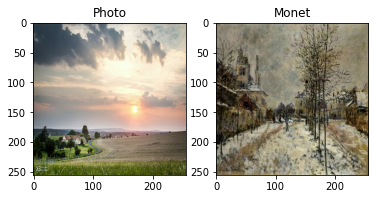

In [74]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Build the Generator

The tutorial uses the UNET architecture originally designed to perform semantic segmentation of biomedical imagery using a limited number of training images. (Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597v1.pdf))

I'm going to summarize some writeups on UNET architecture as well as the paper itself to better understand it before going forward.

### Deeper Understanding and Necessary Background

[Understanding Semantic Segmentation with UNET:](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

Semantic segmentation (also referred to as dense prediction) refers to the labeling of each pixel in an image with the class of what it represents. The output of semantic segmentation should be an image with a resolution similar to the input image, but with each pixel classified.

#### Convolution
For images, a convolution operation takes as input:
- 3 dimensional volume: `Height*Width*Channels`
- A set of `k` filters (kernels, feature extractors): `f*f*Channels`

Typical values of `f` are 3 or 5.

The output of a convolution operation is a 3 dimensional volume: `n_out*n_out*k`

`n_out` can be calculated by `n_out = ((n_in + 2*padding_size - kernel_size)/stride_size) + 1`

This output can be considered (because it is) a map of the features of the input image.

#### Pooling
Pooling reduces the number of parameters in the network by retaining only features that meet certain criteria. For example, max_pooling with a 2x2 filter reduces a 4x4 feature map to a 2x2 pooled feature map by selecting the maximum value from each 2x2 block from the input.

Another name for this is downsampling.

#### Upsampling
Since semantic segmentation should output an image with a resolution equal to the input image, downsampling alone cannot be applied without somehow increasing the resolution. A lot of techniques exist for upsampling, but in the case of UNET a method called transposed convolution is used to recover the information lost during downsampling.

#### Transposed Convolution
Transposed convolution can be considered the opposite of convolution with the input being a low resolution image and the output being a high resolution image. 
Further reference: [Up-sampling with Transposed Convolution](https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)


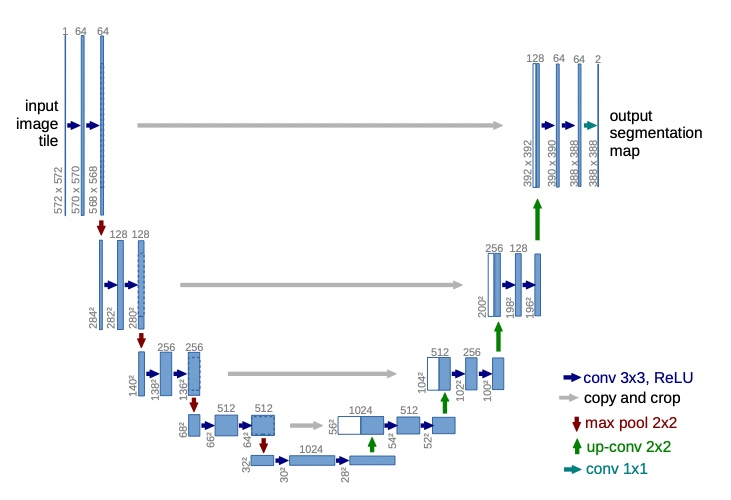

In [76]:
Image(filename="../resources/Unet.jpg")
# UNET architecture.
# Source: U-Net: Convolutional Networks for Biomedical Image Segmentation

In [79]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    '''
    Creates a sequential model from a convolutional layer and (by default) 
    an instance normalization layer.
    '''
    initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    '''
    Creates a sequential model from a convolutional layer and an instance normalization layer. 
    It can be seen here that this is doing the opposite of downsample() as explained above as 
    it uses a transposed convolutional layer, but otherwise identical steps. 
    '''
    initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result
    

### Quick aside: Batch vs. Instance normalization

Reference [this StackOverflow question for a good summary.](https://stackoverflow.com/questions/45463778/instance-normalisation-vs-batch-normalisation) 

For CNN's:
Batch normalization computes one mean and one standard deviation so the distribution of the entire layer is Gaussian.

Instance normalization computes `T` means and `T` standard deviations so the distribution of each image is Gaussian, but jointly they are not. 

Batch normalization tends to add noise to training, and so instance normalization is sometimes preferred for noise-sensitive applications. 

I don't fully understand this yet, or why (or if) a generative model would be more noise-sensitive. 

Further reading can be found [here.](https://arxiv.org/pdf/1602.07868.pdf)

### Generator

In [80]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    
    # bs: batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Discriminator

In [81]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [83]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

Generate an example using the untrained model, then display it. As expected, the output doesn't look like anything. 

2022-02-22 12:30:25.814306: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


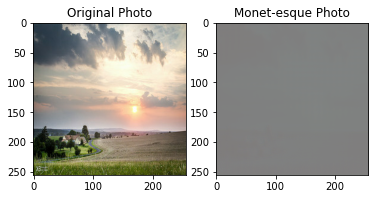

In [84]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Build the CycleGAN Model

In [85]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Define Loss Functions

In [90]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Train the CycleGAN

In [91]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 83s 195ms/step - monet_gen_loss: 5.0785 - photo_gen_loss: 5.1743 - monet_disc_loss: 0.6415 - photo_disc_loss: 0.6357
Epoch 2/25
300/300 [==============================] - 59s 196ms/step - monet_gen_loss: 3.6411 - photo_gen_loss: 3.7242 - monet_disc_loss: 0.6524 - photo_disc_loss: 0.6340
Epoch 3/25
300/300 [==============================] - 59s 196ms/step - monet_gen_loss: 3.5634 - photo_gen_loss: 3.5737 - monet_disc_loss: 0.6381 - photo_disc_loss: 0.6570
Epoch 4/25
300/300 [==============================] - 59s 197ms/step - monet_gen_loss: 3.4473 - photo_gen_loss: 3.4755 - monet_disc_loss: 0.6336 - photo_disc_loss: 0.6413
Epoch 5/25
300/300 [==============================] - 59s 197ms/step - monet_gen_loss: 3.3192 - photo_gen_loss: 3.3670 - monet_disc_loss: 0.6245 - photo_disc_loss: 0.6260
Epoch 6/25
300/300 [==============================] - 59s 197ms/step - monet_gen_loss: 3.2286 - photo_gen_loss: 3.3112 - monet_disc_loss: 0.6135 

## Generate and Visualize

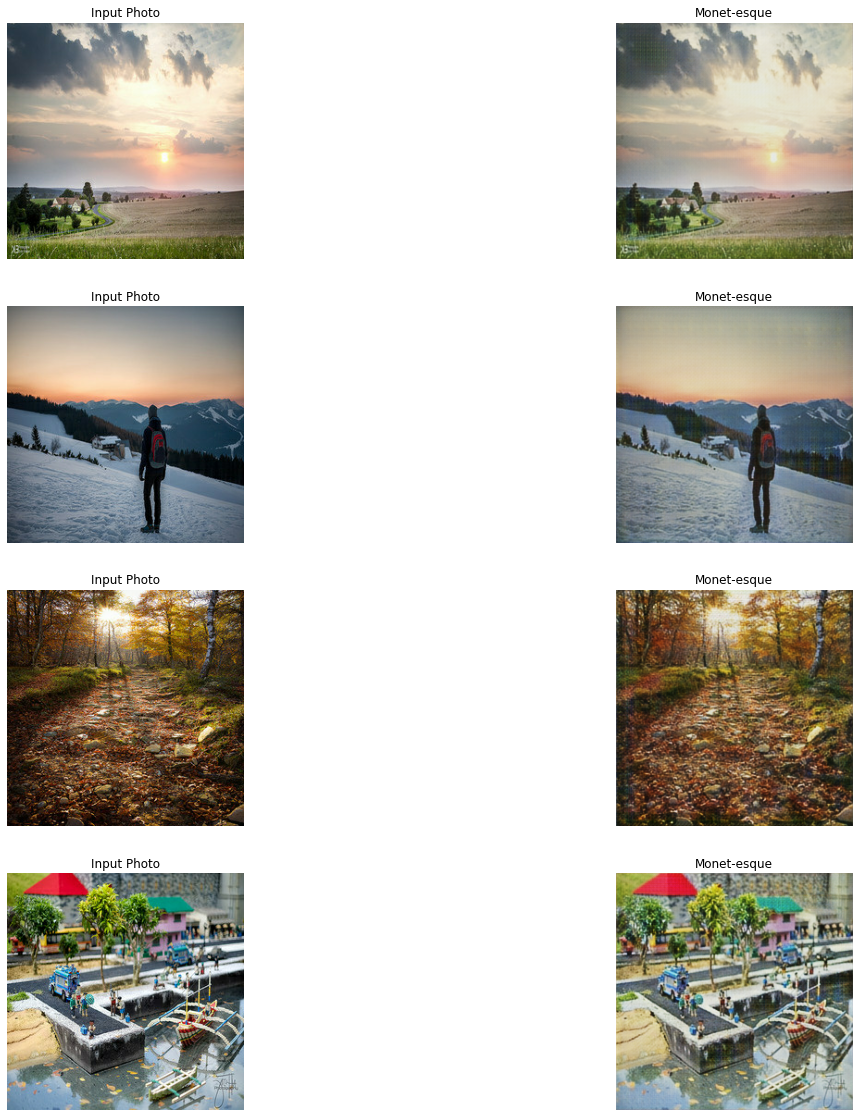

In [97]:
_, ax = plt.subplots(4, 2, figsize=(20, 20))
for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()